# Isolation Forest

In this Jupyter notebook, you'll use the data you collected with your IoT Freezer Monitor to train a machine learning model to detect anomalies in the operation of your freezer. The goal of using a anomaly detection is to send you a warning before freezer has an obvious malfunction.

## What is an Isolation Forest

Isolation Forest is a machine learning algorithem that is used to identify outliers in unlabeled data. Unlabeled data mean that you don't know whether your training data set contains anomalies. The data you're using is most likely unlabeled since hopefully your freezer didn't break while you recording the temperature. 

## How does this work?

The isolation forest looks for outliers by randomly spliting the data recursivly until a point is isolated from all other point, the fewer steps it needs to do this the more likely the point is an outlier.

## Prepare you environment

The sections below prepare

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import join
from sklearn.ensemble import IsolationForest
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
# Helper function
def hours_to_seconds(hours):
    return hours * 3600

In [3]:
# Caluclate how many samples to include per file
# The sample rate should match the code on your temperature monitor
sample_rate = 0.2   # Hz
sample_time = .25     # Hours
samples_per_file = sample_rate * hours_to_seconds(sample_time)

In [4]:
# Path to the dataset from Adafruit.io
dataset_path = './ms_temperature-20200810-1730.csv'

# Load the dataset using pandas
df = pd.read_csv(dataset_path, usecols=[1])

df

,value
0,-9.0000
1,-9.1875
2,-9.2500
3,-9.3750
4,-9.5000
...,...
79842,-13.8750
79843,-13.8125
79844,-13.7500
79845,-13.7500


<function matplotlib.pyplot.show(*args, **kw)>

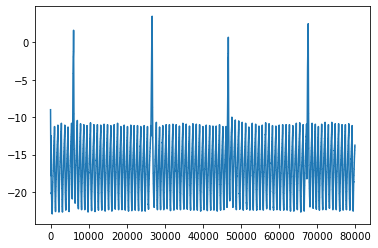

In [5]:
plt.plot(df)
plt.show

In [6]:
# You may want to trim start and end of your data. Espcially if the data at the start of the set is from outside the freezer or while the thermocouple was cooling down.

start_time_trim = 1 # Hours
end_time_trim = 1   # Hours
start_time = hours_to_seconds(start_time_trim)
end_time = len(df.index) - hours_to_seconds(end_time_trim)

df = df.truncate(before=start_time, after=end_time)

# Create one file for each group of samples
arr = []
for i, temp in df.iterrows():
    starting_idx = i
    arr.append(temp)
    if i % samples_per_file == 0 and i != starting_idx:
        sample = pd.DataFrame(data=arr)
        sample.to_csv('./dataset/training15/output'+str(i), index=False, header=False)
        arr = []
        

In [7]:
# Create an array of file names in directory
samples_in_dir = listdir('./dataset/training15')
# Join the path and file name for all files in dicrectory
samples_in_dir = [join('./dataset/training15', sample) for sample in samples_in_dir]

In [8]:
# Set the size of the validation set to 20%
val_size = int(.2 * len(samples_in_dir))

# Randomize the samples
np.random.shuffle(samples_in_dir)

# Split data into training samples and validation samples
val_samples = samples_in_dir[:val_size]
train_samples = samples_in_dir[val_size:]

# Check that the data split correctly
assert(len(val_samples) + len(train_samples) == len(samples_in_dir))

In [9]:
# Test that the data set loaded correctly
np.loadtxt(samples_in_dir[0])

array([-12.25  , -12.25  , -12.25  , -12.25  , -12.1875, -12.125 ,
       -12.125 , -12.125 , -12.125 , -12.125 , -12.0625, -12.0625,
       -12.0625, -12.0625, -12.0625, -12.    , -12.    , -12.    ,
       -12.    , -12.    , -12.    , -12.    , -12.    , -11.9375,
       -11.9375, -11.9375, -11.9375, -11.875 , -11.875 , -11.875 ,
       -11.875 , -11.8125, -11.8125, -11.8125, -11.8125, -11.625 ,
       -11.375 , -11.1875, -11.125 , -11.0625, -11.    , -11.    ,
       -11.    , -11.    , -11.0625, -11.25  , -11.4375, -11.625 ,
       -11.8125, -12.0625, -12.125 , -12.375 , -12.4375, -12.625 ,
       -12.8125, -12.9375, -13.125 , -13.1875, -13.375 , -13.5625,
       -13.6875, -13.8125, -13.9375, -13.9375, -14.    , -14.1875,
       -14.25  , -14.375 , -14.5625, -14.625 , -14.6875, -14.8125,
       -14.8125, -14.875 , -15.    , -15.0625, -15.125 , -15.125 ,
       -15.1875, -15.3125, -15.5   , -15.5625, -15.625 , -15.6875,
       -15.6875, -15.75  , -15.875 , -15.875 , -15.875 , -15.9

In [10]:
def extract_features(sample):
    features = []

    # Median absolute deviation (MAD)
    mad = sp.stats.median_absolute_deviation(sample)

    features.append(mad)
    return np.array(features).flatten()

In [11]:
# Load 1 sample to test feature extraction
sample = np.loadtxt(samples_in_dir[0])
mean = np.mean(sample)
features = extract_features(sample)
print(sample.shape)
print(features.shape)
print(features)

(180,)
(1,)
[4.12348125]


In [12]:
# Function: loop through filenames, creating feature sets
def create_feature_set(filenames):
    x_out = []
    for file in filenames:
        sample = np.loadtxt(file)
        features = extract_features(sample)
        x_out.append(features)
    return np.array(x_out)

In [13]:
# Extract Features for the training and validation sets
training = create_feature_set(train_samples)
val = create_feature_set(val_samples)

In [14]:
# iforest start

clf = IsolationForest(max_samples=100, n_estimators=100, contamination=0.03)
clf.fit(training)
y_pred_train = clf.predict(training)
y_pred_val = clf.predict(val)

print("Training Accuracy:", list(y_pred_train).count(1)/y_pred_train.shape[0])
print("Validation Accuracy:", list(y_pred_val).count(1)/y_pred_val.shape[0])

Training Accuracy: 0.9690721649484536
Validation Accuracy: 0.9305555555555556
